# CleanTechTag 
## (Clean Technologies Tagging) - Deterministic Model
---

### 1. Gathering the mitigation technology catalogue

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
categories = pd.read_excel('../data/mitigation-technology-catalogue.xls')
categories = categories.fillna(method='ffill')
categories.columns = ['sector','technology_group','technology','description','technology_term','source','priority']

In [3]:
categories.head()

,sector,technology_group,technology,description,technology_term,source,priority
0,Energy,Solar energy sources,solar PV,Also “solar photovoltaic”; technology of using...,"photovoltaic, PV, “solar cell”",https://www.ctc-n.org/technologies/solar-pv,1
1,Energy,Solar energy sources,concentrated solar power (CSP),Technology of producing electricity by concent...,"“concentrated solar power”, CSP, “concentrated...",https://setis.ec.europa.eu/technologies/concen...,1
2,Energy,Solar energy sources,solar heating,Technology of capturing the sun's radiation an...,“solar heating”,https://www.ctc-n.org/technologies/solar-heating,1
3,Energy,Solar energy sources,solar dryer,"Technology of drying substances, especially fo...",“solar dryer”,https://www.ctc-n.org/technologies/solar-dryer,0
4,Energy,Solar energy sources,solar water pump,Technology of powering electrical water pumps ...,“solar water pump”,https://www.ctc-n.org/technologies/solar-water...,0


In [4]:
len(categories.sector.unique())

6

In [5]:
matrix = []
for term in categories['technology_term']:
    row = [x.strip() for x in term.split(',')]
    row = [i.replace('“', '').replace('”', '') for i in row]
    matrix.append(row)
categories['technology_term'] = matrix

---

### 2. Reading up cordis H2020 projects data source
https://data.europa.eu/euodp/en/data/dataset/cordisH2020projects

*To replicate the results use the copy made*

In [ ]:
cordish2020 = pd.read_excel('../data/cordis-h2020projects.xlsx')

*To get the latest data go to the source endpoint*

In [4]:
#cordish2020 = pd.read_csv('https://cordis.europa.eu/data/cordis-h2020projects.csv', sep=';',error_bad_lines=False)

In [7]:
cordish2020.columns

Index(['rcn', 'id', 'acronym', 'status', 'programme', 'topics',
       'frameworkProgramme', 'title', 'startDate', 'endDate', 'projectUrl',
       'objective', 'totalCost', 'ecMaxContribution', 'call', 'fundingScheme',
       'coordinator', 'coordinatorCountry', 'participants',
       'participantCountries', 'subjects'],
      dtype='object')

In [9]:
cordish2020['totalCost'] = [float(str(i).replace(',', '.')) for i in cordish2020['totalCost']]
cordish2020['ecMaxContribution'] = [float(str(i).replace(',', '.')) for i in cordish2020['ecMaxContribution']]
cordish2020['objective'] = [str(i) for i in cordish2020['objective']]
cordish2020['startDate'] = cordish2020['startDate'].map(pd.Timestamp)
cordish2020['endDate'] = cordish2020['endDate'].map(pd.Timestamp)

In [10]:
# Total proyects
len(cordish2020)

27370

#### Project's objective example

In [11]:
cordish2020.loc[13]['objective']

'With 115 organisations across 21 European countries, The Distributed System of Scientific Collections (DiSSCo) represents today the largest ever formal agreement between organisations of this type, in the world. These organisations have joined forces to develop and operate as a distributed pan-European Research Infrastructure. The DiSSCo RI works for the digital unification of all European natural science assets under common curation and access policies and practices that aim to make the data easily Findable, more Accessible, Interoperable and Reusable (FAIR). DiSSCo will deploy a comprehensive portfolio of services across three main categories: a) e-Science Services, b) Physical and Remote Access Services and c) Support and Training Services.\n\nDiSSCo Prepare acts as the main vehicle through which DiSSCo RI will raise its overall maturity and set itself in a position to implement its construction programme. DiSSCo Prepare aims at 1) improving the overall Implementation Readiness Lev

---

### 3. Deterministic text labeling
#### Using [Flashtext](https://flashtext.readthedocs.io/en/latest/) algorithm for easy regex 

In [12]:
from flashtext import KeywordProcessor

In [13]:
def extract(vec, dictionary, info=False):
    empty = []
    for line in vec:
        empty.append(dictionary.extract_keywords(line, span_info=info))
    return empty

In [14]:
# unique list of technology group
technology_group = list(categories['technology_group'].unique())
len(technology_group)

24

In [16]:
dictionary1 = KeywordProcessor()
dictionary1.add_keywords_from_list(technology_group)
extracted1 = extract(cordish2020['objective'], dictionary1)

In [17]:
cordish2020['matches_group'] = [list(set(i)) if len(i)>0 else '' for i in extracted1]
cordish2020['count_matches_group'] = [len(i) for i in extracted1]
cordish2020['count_unique_matches_group'] = [len(set(i)) for i in extracted1]

In [18]:
# unique list of technology term
technology_term = [y for x in categories['technology_term'] for y in x if y != '']
len(technology_term)

237

In [19]:
#adding the new list of terms
dictionary2 = KeywordProcessor()
dictionary2.add_keywords_from_list(technology_term)
extracted2 = extract(cordish2020['objective'], dictionary2)
cordish2020['matches_technology'] = [list(set(i)) if len(i)>0 else '' for i in extracted2]
cordish2020['count_matches_technology'] = [len(i) for i in extracted2]
cordish2020['count_unique_matches_technology'] = [len(set(i)) for i in extracted2]

In [20]:
#cordish2020.head()

In [21]:
# filter only the rows with at least one match
cordish2020['count_matches'] = cordish2020['count_matches_group'] + cordish2020['count_matches_technology'] 
cordish2020matches = cordish2020[cordish2020['count_matches_technology'] > 0 ] #at least one match with technology term

In [22]:
cordish2020matches.columns

Index(['rcn', 'id', 'acronym', 'status', 'programme', 'topics',
       'frameworkProgramme', 'title', 'startDate', 'endDate', 'projectUrl',
       'objective', 'totalCost', 'ecMaxContribution', 'call', 'fundingScheme',
       'coordinator', 'coordinatorCountry', 'participants',
       'participantCountries', 'subjects', 'matches_group',
       'count_matches_group', 'count_unique_matches_group',
       'matches_technology', 'count_matches_technology',
       'count_unique_matches_technology', 'count_matches'],
      dtype='object')

In [23]:
len(cordish2020matches)

2323

---

### 4. Matches analysis

#### Percentage of Matches

In [24]:
print(100*len(cordish2020matches)/len(cordish2020))

8.487394957983193


In [25]:
#this is the list we need to compare with the probabilistic
cordish2020matches.id[:20]

6      875629
31     850626
32     870245
39     887865
40     889249
53     888396
64     888180
73     888528
87     883679
95     882777
103    870620
108    887106
113    871115
128    875029
133    870403
141    886997
143    887603
161    889190
175    821087
178    887525
Name: id, dtype: int64

#### Projects with more matches

In [26]:
cordish2020matches[['acronym','title','endDate','ecMaxContribution','matches_group','count_matches']]\
    .sort_values('count_matches', ascending=False)\
    .head(10)

,acronym,title,endDate,ecMaxContribution,matches_group,count_matches
19064,STEMM-CCS,Strategies for Environmental Monitoring of Mar...,2020-02-29,15918369.00,"[CCS, Storage]",28
27153,ACT,Accellerating CCS technologies as a new low-ca...,2021-01-31,11889929.23,"[CCS, Storage]",27
22730,FLOATMAST,An Innovative Wind Resource Assessment Tension...,2015-11-30,50000.00,[Wind],24
20836,WITRO,Wind and Turbulence Radar for Offshore wind en...,2015-12-31,50000.00,[Wind],22
9738,Small-scale CSP,Numerical and experimental analysis of a novel...,2020-05-31,212194.80,[Storage],22
3314,FLOAWER,FLOAting Wind Energy netwoRk,2023-10-31,3500381.88,[Wind],20
23704,SENSIBLE,Storage-Enabled Sustainable Energy for Buildin...,2018-12-31,11842396.76,"[Storage, Energy management]",20
15699,FLOWSPA,Floating Offshore Wind Support Platform and As...,2017-09-30,50000.00,[Wind],19
1846,REMOTE,Remote area Energy supply with Multiple Option...,2021-12-31,4995950.25,"[Fuel, Wind, Storage]",19
12828,acteno,Industrial Energy Storage Integration - develo...,2018-08-31,143900.00,[Storage],19


In [27]:
def get_terms_matrix(vector_of_terms, all_terms):
    matrix = []
    for vector in vector_of_terms:
        ind_vector = [0] * len(all_terms)
        for v in vector:
            for idx, i in enumerate(all_terms):
                if v == i:
                    ind_vector[idx] = 1
        matrix.append(ind_vector)
    table = pd.DataFrame(matrix)
    return table

In [28]:
all_technology_terms = [i for i in set([*list(categories['technology_group']),*list(technology_term)])]

In [29]:
len(all_technology_terms)

249

In [30]:
all_technology_terms[:10]

['biofuel',
 'inert anode',
 'methane capture',
 'solar cell',
 'vehicle-to-grid',
 'agrosylviculture',
 'alternate wetting and drying',
 'low green house gas lighting',
 'low green house fertiliser',
 'lightweight transport']

In [31]:
#expected to have 225 columns
matches_technology_table = get_terms_matrix(list(cordish2020matches['matches_technology']), all_technology_terms)
matches_group_table = get_terms_matrix(list(cordish2020matches['matches_group']), all_technology_terms)

In [32]:
matches_table = matches_group_table + matches_technology_table
matches_table.columns = all_technology_terms
matches_table['number_unique_terms'] = matches_table.sum(axis=1)

In [33]:
matches_table.head()

,biofuel,inert anode,methane capture,solar cell,vehicle-to-grid,agrosylviculture,alternate wetting and drying,low green house gas lighting,low green house fertiliser,lightweight transport,...,power-to-methane,direct casting,Use of innovative materials,conservation tillage,RAPS,recycling,midseason drainage,converted gas,offshore wind,number_unique_terms
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [34]:
len(matches_table) == len(cordish2020matches)

True

In [35]:
full_table_tech_matches = \
    pd.concat([cordish2020matches.reset_index(), 
               matches_table], 
              axis=1)\
    .sort_values(['count_matches','number_unique_terms'],
                 ascending=False).reset_index()

In [36]:
len(full_table_tech_matches)

2323

#### Writing results

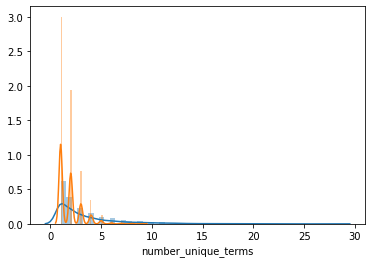

In [37]:
import seaborn as sns
sns.distplot(full_table_tech_matches['count_matches'])
sns.distplot(full_table_tech_matches['number_unique_terms'])

In [38]:
full_table_tech_matches.groupby('count_matches').count()['number_unique_terms']

count_matches
1     782
2     487
3     296
4     207
5     129
6     104
7      72
8      52
9      47
10     32
11     29
12     25
13     16
14     10
15      8
16      8
17      5
18      2
19      5
20      2
22      2
24      1
27      1
28      1
Name: number_unique_terms, dtype: int64

In [39]:
full_table_tech_matches[['id','acronym','title',
                         'objective','startDate',
                         'endDate','ecMaxContribution',
                         'coordinator', 'coordinatorCountry',
                         'matches_group','matches_technology',
                         'number_unique_terms','count_matches']]\
    .to_csv('../data/cleantechtag_deterministic_results.csv')

In [40]:
termsT = full_table_tech_matches.iloc[:,33:-1].T
termsT['sum'] = termsT.sum(axis=1)

In [41]:
termsT.sort_values('sum', ascending=False)['sum'].head(10)

renewable energy    499
Storage             453
recycling           343
Fuel                321
energy storage      257
photovoltaic        198
PV                  198
Wind                197
fuel cell           119
Waste management     97
Name: sum, dtype: int64

#### Percentage of matched technologies 

In [42]:
len(termsT[termsT['sum']>0])/len(termsT)

0.46747967479674796